In [11]:
import os
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from tensorflow.keras import models, layers

In [2]:
import zipfile
# Unzip the archive
local_zip = 'Capstone.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [3]:
dataset_dir = os.path.join('Capstone')
classes = ['Pants', 'Skirt', 'Shirt', 'Blazer', 'Tshirt', 'Jacket', 'Short', 'Dress', 'Top']
training_percentage = 0.9
training_dataset_dir = 'training'
validation_dataset_dir = 'validation'

# Membuat direktori untuk training dan validation jika belum ada
os.makedirs(training_dataset_dir, exist_ok=True)
os.makedirs(validation_dataset_dir, exist_ok=True)

for dirname in classes:
    classpath = os.path.join(dataset_dir, dirname)
    training_classpath = os.path.join(training_dataset_dir, dirname)
    validation_classpath = os.path.join(validation_dataset_dir, dirname)
    
    # Membuat direktori untuk masing-masing kelas jika belum ada
    os.makedirs(training_classpath, exist_ok=True)
    os.makedirs(validation_classpath, exist_ok=True)
    
    # Mendapatkan daftar file dalam direktori kelas
    file_list = os.listdir(classpath)
    training_length = int(training_percentage * len(file_list))
    
    counter = 0
    for filename in file_list:
        filepath = os.path.join(classpath, filename)
        if counter < training_length:
            shutil.move(filepath, training_classpath)
        else:
            shutil.move(filepath, validation_classpath)
        counter += 1

In [21]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator (
    rescale = 1./255,
    zoom_range = 0.25,
    horizontal_flip = True,
    vertical_flip = False
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator (
    rescale = 1./255
)

In [22]:
training_generator = training_datagen.flow_from_directory(
    training_dataset_dir,
    target_size = (150, 150),
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dataset_dir,
    target_size = (150, 150),
    class_mode = 'categorical'
)
type_dict = training_generator.class_indices
print(type_dict)

Found 3070 images belonging to 9 classes.
Found 347 images belonging to 9 classes.
{'Blazer': 0, 'Dress': 1, 'Jacket': 2, 'Pants': 3, 'Shirt': 4, 'Short': 5, 'Skirt': 6, 'Top': 7, 'Tshirt': 8}


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 17, 17, 128)      

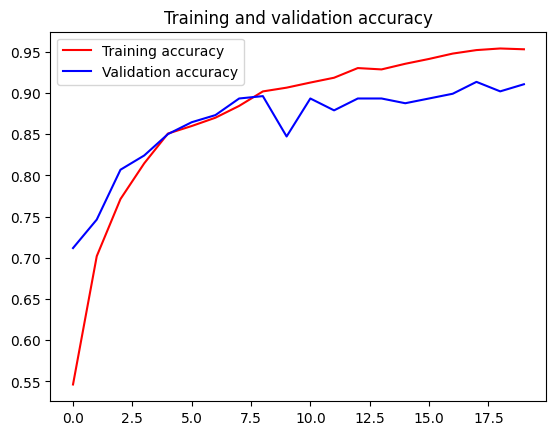

<Figure size 640x480 with 0 Axes>

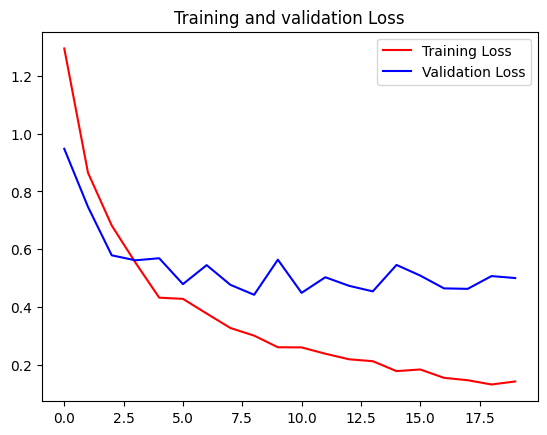

<Figure size 640x480 with 0 Axes>

In [23]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])
model.summary()
# Mengkompilasi Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Melatih Model
history = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Menyimpan Model
model.save('fashion_classifier_model.h5')

# Plot hasil pelatihan jika diperlukan

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [28]:
import tensorflow as tf
import json
import flatbuffers
from tensorflow.lite.python import schema_py_generated as schema

# Step 1: Convert .h5 model to .tflite
def convert_h5_to_tflite(h5_model_path, tflite_model_path):
    model = tf.keras.models.load_model(h5_model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    return tflite_model

# Helper function to decode bytes to string if needed
def decode_bytes(value):
    return value.decode('utf-8') if isinstance(value, bytes) else value

# Step 2: Extract model info as JSON
def extract_model_info_as_json(tflite_model, json_output_path):
    model_object = schema.Model.GetRootAsModel(tflite_model, 0)
    model_dict = {}
    model_dict["description"] = decode_bytes(model_object.Description())
    model_dict["version"] = model_object.Version()
    model_dict["subgraphs"] = []
    for i in range(model_object.SubgraphsLength()):
        subgraph = model_object.Subgraphs(i)
        subgraph_dict = {"tensors": [], "inputs": [], "outputs": []}
        for j in range(subgraph.TensorsLength()):
            tensor = subgraph.Tensors(j)
            tensor_dict = {
                "name": decode_bytes(tensor.Name()),
                "shape": tensor.ShapeAsNumpy().tolist(),
                "type": tensor.Type()
            }
            subgraph_dict["tensors"].append(tensor_dict)
        subgraph_dict["inputs"] = subgraph.InputsAsNumpy().tolist()
        subgraph_dict["outputs"] = subgraph.OutputsAsNumpy().tolist()
        model_dict["subgraphs"].append(subgraph_dict)

    with open(json_output_path, 'w') as f:
        json.dump(model_dict, f, indent=4)

# Step 3: Save binary data
def save_binary_data(tflite_model, binary_output_path):
    with open(binary_output_path, 'wb') as f:
        f.write(tflite_model)

# Paths
h5_model_path = 'fashion_classifier_model.h5'
tflite_model_path = 'model.tflite'
json_output_path = 'model.json'
binary_output_path = 'model.bin'

# Convert and save
tflite_model = convert_h5_to_tflite(h5_model_path, tflite_model_path)
extract_model_info_as_json(tflite_model, json_output_path)
save_binary_data(tflite_model, binary_output_path)

INFO:tensorflow:Assets written to: C:\Users\corne\AppData\Local\Temp\tmp4i2_g61j\assets


INFO:tensorflow:Assets written to: C:\Users\corne\AppData\Local\Temp\tmp4i2_g61j\assets
